In [2]:
import os
import cv2
import dlib
import time
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from scipy.spatial import distance as dist
from imutils import face_utils
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from collections import deque

LOADING DATASET

In [3]:
IMAGE_SIZE = 64  # You can adjust this

def load_data(data_dir):
    data = []
    labels = []
    categories = os.listdir(data_dir)
    for category in categories:
        folder = os.path.join(data_dir, category)
        if not os.path.isdir(folder):
            continue
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
            img = img / 255.0  # normalize
            data.append(img)
            labels.append(category)
    return np.array(data), np.array(labels)

# Load train and test data
X_train, y_train = load_data("/Users/lakshitrahulbantupalli/Desktop/everything/Projects/DrowsyDetection/dataset_new/train")
X_test, y_test = load_data("/Users/lakshitrahulbantupalli/Desktop/everything/Projects/DrowsyDetection/dataset_new/test")

# Label encode
le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.transform(y_test))

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Labels: {le.classes_}")

Train shape: (4890, 64, 64, 3)
Test shape: (2856, 64, 64, 3)
Labels: ['Closed' 'Open' 'no_yawn' 'yawn']


PHASE I
    THE BRAIN OF THE MODEL USING CNN

In [4]:

# Paths
train_dir = "/Users/lakshitrahulbantupalli/Desktop/everything/Projects/DrowsyDetection/dataset_new/train"
test_dir = "/Users/lakshitrahulbantupalli/Desktop/everything/Projects/DrowsyDetection/dataset_new/test"

# Parameters
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 4  # ['Closed', 'Open', 'no_yawn', 'yawn']

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    epochs=25,
    validation_data=test_data,
    callbacks=[early_stop]
)

# Evaluate
test_data.reset()
pred = model.predict(test_data)
pred_classes = np.argmax(pred, axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Metrics
print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

print("Confusion Matrix:\n")
print(confusion_matrix(true_classes, pred_classes))

# Save the model
model.save("drowsiness_cnn_model_improved.h5")

Found 4890 images belonging to 4 classes.
Found 2856 images belonging to 4 classes.


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 30s 184ms/step - accuracy: 0.4374 - loss: 2.6200 - val_accuracy: 0.4569 - val_loss: 1.4348
Epoch 2/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.6328 - loss: 1.3109 - val_accuracy: 0.5210 - val_loss: 1.3332
Epoch 3/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 26s 172ms/step - accuracy: 0.6519 - loss: 1.1762 - val_accuracy: 0.7223 - val_loss: 0.9203
Epoch 4/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - accuracy: 0.7000 - loss: 1.0201 - val_accuracy: 0.7850 - val_loss: 0.8295
Epoch 5/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 203ms/step - accuracy: 0.6981 - loss: 0.9862 - val_accuracy: 0.8120 - val_loss: 0.8077
Epoch 6/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 28s 184ms/step - accuracy: 0.7238 - loss: 0.9349 - val_accuracy: 0.7878 - val_loss: 0.8017
Epoch 7/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 23s 149ms/step - accuracy: 0.7071 - loss: 0.9584 - val_accuracy: 0.8148 - val_loss: 0.7847
Epoch 8/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 29s 187ms/step - accuracy: 0.7275 - loss: 0


Classification Report:

              precision    recall  f1-score   support

      Closed       0.94      0.97      0.95      1301
        Open       0.97      0.94      0.95      1340
     no_yawn       0.61      0.65      0.63       109
        yawn       0.60      0.58      0.59       106

    accuracy                           0.93      2856
   macro avg       0.78      0.79      0.78      2856
weighted avg       0.93      0.93      0.93      2856

Confusion Matrix:

[[1256   41    1    3]
 [  82 1258    0    0]
 [   0    0   71   38]
 [   0    0   44   62]]


VISUALISATION OF PHASE I

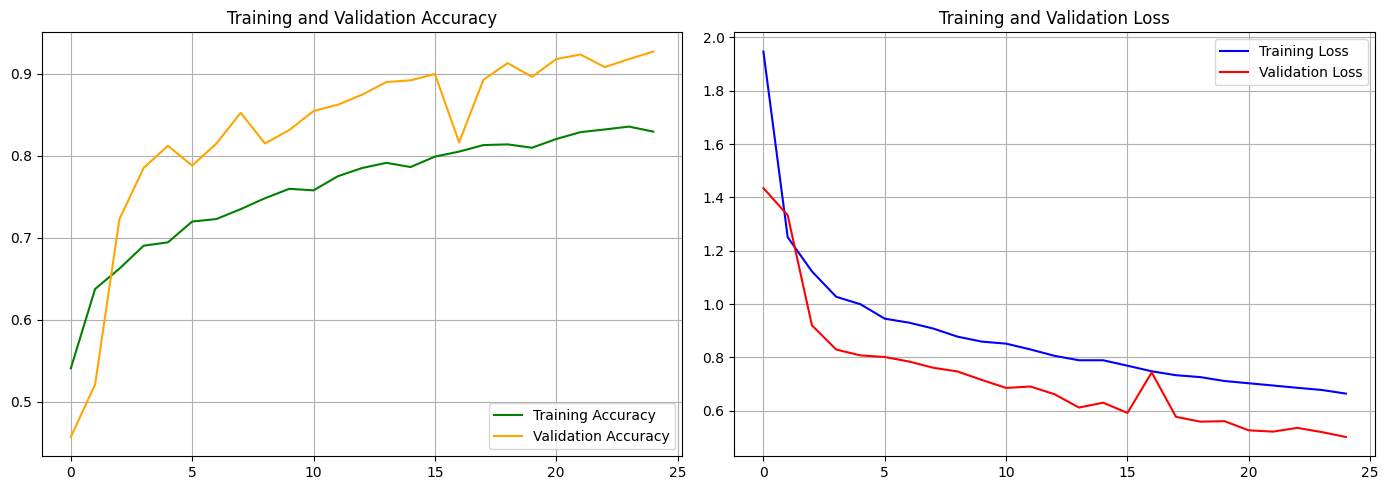

In [5]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='green')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call this after training
plot_training_history(history)

SMOOTHING THINGS OUT BY ADDIND LEARNING RATE SCHEDULING

In [6]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [7]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Update callbacks list
callbacks = [early_stop, reduce_lr]

In [9]:
history = model.fit(
    train_data,
    epochs=25,
    validation_data=test_data,
    callbacks=callbacks
)

Epoch 1/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - accuracy: 0.8479 - loss: 0.6498 - val_accuracy: 0.9027 - val_loss: 0.5415 - learning_rate: 1.0000e-04
Epoch 2/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 26s 172ms/step - accuracy: 0.8468 - loss: 0.6374 - val_accuracy: 0.9233 - val_loss: 0.5012 - learning_rate: 1.0000e-04
Epoch 3/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 26s 170ms/step - accuracy: 0.8550 - loss: 0.6225 - val_accuracy: 0.9254 - val_loss: 0.4852 - learning_rate: 1.0000e-04
Epoch 4/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 26s 171ms/step - accuracy: 0.8512 - loss: 0.6352 - val_accuracy: 0.9156 - val_loss: 0.5128 - learning_rate: 1.0000e-04
Epoch 5/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 26s 170ms/step - accuracy: 0.8464 - loss: 0.6252 - val_accuracy: 0.9198 - val_loss: 0.4987 - learning_rate: 1.0000e-04
Epoch 6/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 26s 171ms/step - accuracy: 0.8516 - loss: 0.6214 - val_accuracy: 0.9233 - val_loss: 0.4791 - learning_rate: 1.0000e-04
Epoch 7/25
153/153 ━━━━━━━━━━━━━━━━━━━━ 26s 17

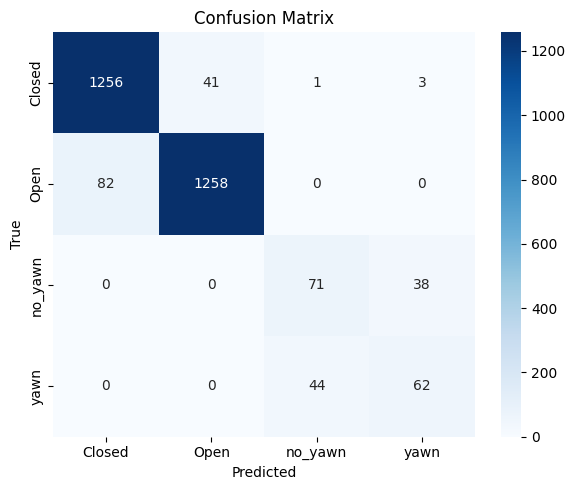

In [10]:
# Confusion Matrix Plot
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Number of misclassified images: 184


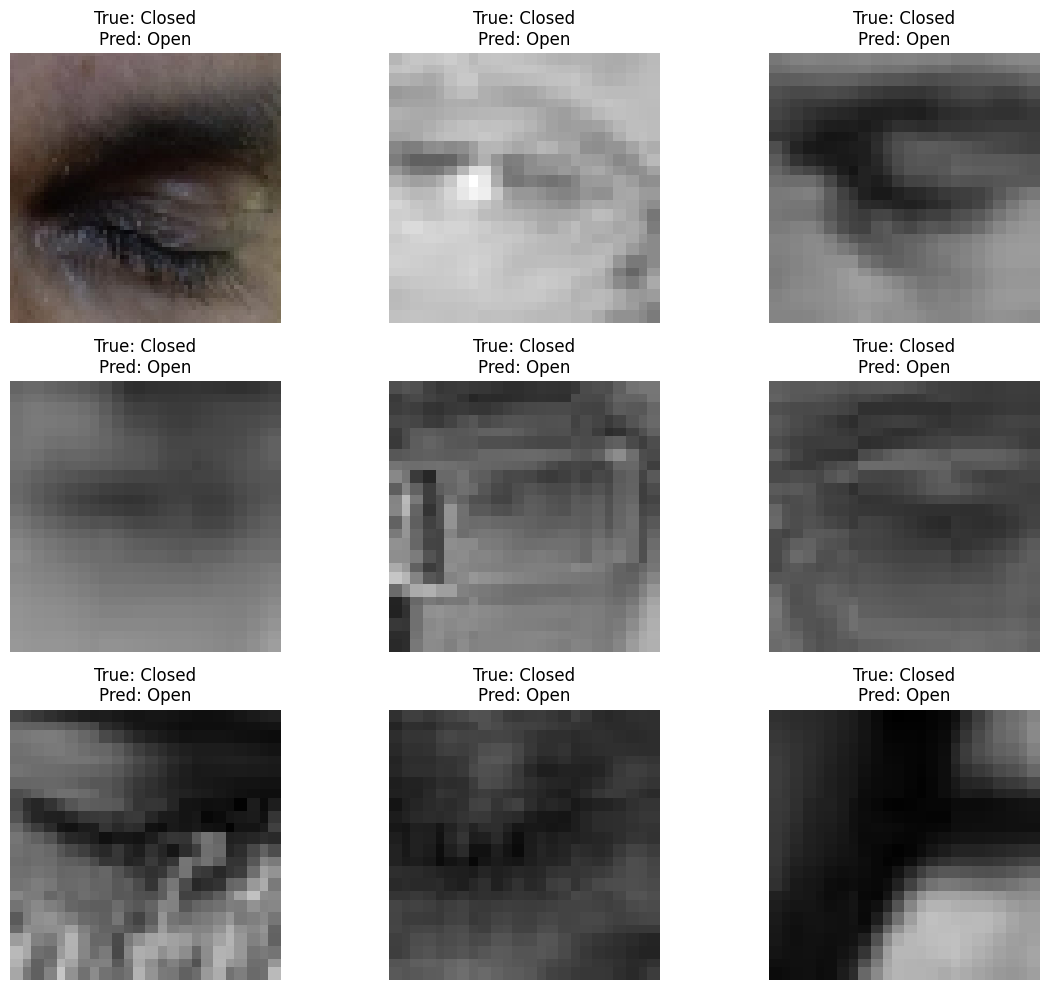

In [11]:
# Get all test images and labels
test_data.reset()
images = []
labels = []

for i in range(len(test_data)):
    img_batch, label_batch = test_data[i]
    for img, label in zip(img_batch, label_batch):
        images.append(img)
        labels.append(np.argmax(label))

images = np.array(images)
labels = np.array(labels)

# Predictions
pred_probs = model.predict(images, verbose=0)
pred_labels = np.argmax(pred_probs, axis=1)

# Find misclassified indices
misclassified_idx = np.where(pred_labels != labels)[0]
print(f"Number of misclassified images: {len(misclassified_idx)}")

# Plot misclassified images
plt.figure(figsize=(12, 10))
for i, idx in enumerate(misclassified_idx[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx])
    plt.title(f"True: {class_labels[labels[idx]]}\nPred: {class_labels[pred_labels[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
import numpy as np

# Re-run prediction if needed
test_data.reset()
pred = model.predict(test_data, verbose=0)
pred_classes = np.argmax(pred, axis=1)
true_classes = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Identify misclassified indices
misclassified_idx = np.where(pred_classes != true_classes)[0]
print(f"Total misclassified images: {len(misclassified_idx)}")

# Print details
for idx in misclassified_idx[:10]:  # Print first 10 as example
    true_label = class_labels[true_classes[idx]]
    pred_label = class_labels[pred_classes[idx]]
    filename = test_data.filenames[idx]
    print(f"{filename} | True: {true_label} | Predicted: {pred_label}")

Total misclassified images: 184
Closed/_279.jpg | True: Closed | Predicted: Open
Closed/closed_eye_0020.jpg_face_1_R.jpg | True: Closed | Predicted: Open
Closed/closed_eye_0165.jpg_face_2_L.jpg | True: Closed | Predicted: Open
Closed/closed_eye_0178.jpg_face_1_R.jpg | True: Closed | Predicted: Open
Closed/closed_eye_0218.jpg_face_1_R.jpg | True: Closed | Predicted: Open
Closed/closed_eye_0344.jpg_face_2_L.jpg | True: Closed | Predicted: Open
Closed/closed_eye_0360.jpg_face_1_R.jpg | True: Closed | Predicted: Open
Closed/closed_eye_0395.jpg_face_1_R.jpg | True: Closed | Predicted: Open
Closed/closed_eye_0397.jpg_face_2_R.jpg | True: Closed | Predicted: Open
Closed/closed_eye_0573.jpg_face_2_L.jpg | True: Closed | Predicted: Open


PHASE II INTELLIGENT SYSTEM

In [13]:
import cv2
import numpy as np
from keras.models import load_model
from collections import deque
from imutils import face_utils
import dlib
import math
import time

In [14]:
# Load trained CNN model (eye & mouth state classifier)
model = load_model("drowsiness_cnn_model_improved.h5")
labels = ['Closed', 'Open', 'no_yawn', 'yawn']

In [15]:

# Load facial landmark predictor for head pose estimation
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Constants
SEQ_LENGTH = 30  # Buffer length
EYE_CLOSED_FRAMES = 15  # >15 consecutive frames (~2 seconds at 30 FPS)
YAWN_THRESHOLD = 3  # Number of yawns in 30 frames
HEAD_PITCH_THRESHOLD = 15  # Pitch threshold for nodding

# Buffer
sequence = deque(maxlen=SEQ_LENGTH)
eye_closed_counter = 0
yawn_counter = 0

RuntimeError: Unable to open shape_predictor_68_face_landmarks.dat

In [16]:
# Head pose estimation helpers
def get_head_pose(shape):
    image_points = np.array([
        shape[30],     # Nose tip
        shape[8],      # Chin
        shape[36],     # Left eye left corner
        shape[45],     # Right eye right corner
        shape[48],     # Left Mouth corner
        shape[54]      # Right mouth corner
    ], dtype="double")

    model_points = np.array([
        (0.0, 0.0, 0.0),             # Nose tip
        (0.0, -330.0, -65.0),        # Chin
        (-225.0, 170.0, -135.0),     # Left eye left corner
        (225.0, 170.0, -135.0),      # Right eye right corner
        (-150.0, -150.0, -125.0),    # Left Mouth corner
        (150.0, -150.0, -125.0)      # Right mouth corner
    ])

    size = (640, 480)
    focal_length = size[1]
    center = (size[1] / 2, size[0] / 2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double"
    )
    dist_coeffs = np.zeros((4, 1))

    success, rotation_vector, translation_vector = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs)

    rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
    proj_matrix = np.hstack((rvec_matrix, translation_vector))
    eulerAngles = cv2.decomposeProjectionMatrix(proj_matrix)[6]
    pitch, yaw, roll = eulerAngles.flatten()

    return pitch

# Preprocess for CNN
def preprocess_roi(roi):
    roi = cv2.resize(roi, (64, 64))
    roi = roi.astype("float32") / 255.0
    roi = np.expand_dims(roi, axis=0)
    return roi

PHASE II VERSION II LSTM PIPELINE

Epoch 1/25


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8591 - loss: 0.5121 - val_accuracy: 1.0000 - val_loss: 0.0930
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0982 - val_accuracy: 1.0000 - val_loss: 0.0135
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0254 - val_accuracy: 1.0000 - val_loss: 0.0037
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0150 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 1.0000 - val_loss: 8.6864e-04
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 5.5388e-04
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 3.6283e-04
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - 


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        96

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



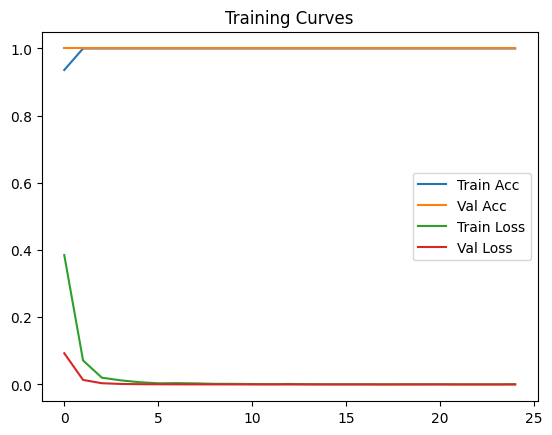

In [17]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# -----------------------------
# Generate Smarter Dummy Sequences
# -----------------------------

def generate_sequence(is_drowsy, seq_len=30):
    sequence = []
    closed_eye_frames = 0
    for _ in range(seq_len):
        if is_drowsy:
            eye = np.random.choice([1, 1, 0], p=[0.6, 0.3, 0.1])  # mostly closed
            mouth = np.random.choice([1, 0], p=[0.6, 0.4])        # mostly yawn
            pitch = np.random.normal(loc=7.5, scale=1.2)          # more nodding
        else:
            eye = np.random.choice([0, 1], p=[0.85, 0.15])        # mostly open
            mouth = np.random.choice([0, 1], p=[0.9, 0.1])        # mostly no yawn
            pitch = np.random.normal(loc=2.0, scale=0.8)          # upright

        closed_eye_frames += (eye == 1)
        sequence.append([eye, mouth, pitch])

    sequence = np.array(sequence)
    
    # Enforce rule: if eyes closed too many frames, override label to drowsy
    is_drowsy = 1 if closed_eye_frames >= 20 else int(is_drowsy)
    return sequence, is_drowsy

# Generate dataset with enhanced labels
X, y = [], []
for _ in range(1000):
    drowsy = (_ < 500)  # First 500 are meant to be drowsy
    seq, label = generate_sequence(drowsy)
    X.append(seq)
    y.append(label)

X = np.array(X)
y = np.array(y)

# -----------------------------
# Train/Test Split
# -----------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# -----------------------------
# Define & Train LSTM Model
# -----------------------------

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(30, 3)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2)

# -----------------------------
# Evaluate
# -----------------------------

y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_binary))

# -----------------------------
# Save Model
# -----------------------------

model.save("drowsiness_lstm_model.h5")

# -----------------------------
# Plot training curves
# -----------------------------

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Curves")
plt.show()

PIPELINING

In [18]:
import cv2
import numpy as np
import time
from collections import deque
from tensorflow.keras.models import load_model

In [19]:

# Load pre-trained models
cnn_model = load_model("drowsiness_cnn_model_improved.h5")  # Your CNN model for frame-level prediction
lstm_model = load_model("drowsiness_lstm_model.h5")

# Initialize sequence buffer for LSTM
sequence_buffer = deque(maxlen=30)

# Map CNN output class index to label
class_labels = ['Closed', 'Open', 'no_yawn', 'yawn']

def get_eye_state(eye_pred):
    return 1 if eye_pred == 'Closed' else 0

def get_mouth_state(mouth_pred):
    return 1 if mouth_pred == 'yawn' else 0

def estimate_head_pose(frame):
    # Dummy pitch estimator — replace with actual head pose logic
    return np.random.normal(loc=2.5, scale=1.0)  # Simulate mild pitch

def preprocess_frame(frame):
    face_img = cv2.resize(frame, (64, 64))
    face_img = face_img.astype("float32") / 255.0
    return np.expand_dims(face_img, axis=0)

In [ ]:
# ===============================
# 🔁 IMPORT LIBRARIES
# ===============================
import cv2
import dlib
import numpy as np
from tensorflow.keras.models import load_model
from imutils import face_utils
from collections import deque

# ===============================
# 🔧 LOAD MODELS
# ===============================
cnn_model = load_model("drowsiness_cnn_model_improved.h5")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# ===============================
# 📋 LABELS MAPPING
# ===============================
class_labels = ['Closed', 'Open', 'no_yawn', 'yawn']

# ===============================
# 🧠 DROWSINESS THRESHOLDS
# ===============================
EYE_CLOSED_FRAMES_THRESHOLD_1 = 15  # for moderate drowsiness (~1.5s)
EYE_CLOSED_FRAMES_THRESHOLD_2 = 25  # for severe drowsiness (~3s)
YAWN_COUNT_THRESHOLD = 3            # within last 30 frames
HEAD_PITCH_THRESHOLD = 15           # for head nod detection
SEQ_LENGTH = 30

# ===============================
# 📊 TRACKING STATE
# ===============================
eye_closed_frames = 0
yawn_count_window = deque(maxlen=SEQ_LENGTH)

# ===============================
# 🎯 HELPER FUNCTIONS
# ===============================

def extract_roi(frame, shape, points):
    (x, y, w, h) = cv2.boundingRect(np.array([shape[points[0]:points[1]]]))
    roi = frame[y:y + h, x:x + w]
    if roi.size == 0:
        return None
    roi = cv2.resize(roi, (64, 64))
    roi = roi.astype("float32") / 255.0
    return np.expand_dims(roi, axis=0)

def get_head_pitch(shape, frame_shape):
    image_points = np.array([
        shape[30], shape[8], shape[36], shape[45], shape[48], shape[54]
    ], dtype="double")

    model_points = np.array([
        (0.0, 0.0, 0.0), (0.0, -330.0, -65.0),
        (-225.0, 170.0, -135.0), (225.0, 170.0, -135.0),
        (-150.0, -150.0, -125.0), (150.0, -150.0, -125.0)
    ])

    size = (frame_shape[1], frame_shape[0])
    focal_length = size[1]
    center = (size[1] / 2, size[0] / 2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double"
    )
    dist_coeffs = np.zeros((4, 1))

    _, rot_vec, trans_vec = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs)
    rmat, _ = cv2.Rodrigues(rot_vec)
    proj_matrix = np.hstack((rmat, trans_vec))
    _, _, _, _, _, _, euler_angles = cv2.decomposeProjectionMatrix(proj_matrix)
    pitch = euler_angles[0][0]
    return pitch

# ===============================
# 🎥 START VIDEO CAPTURE
# ===============================
cap = cv2.VideoCapture(0)

print("Starting Multi-Level Drowsiness Detection. Press 'q' to quit.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 0)

    for face in faces:
        shape = predictor(gray, face)
        shape = face_utils.shape_to_np(shape)

        # Extract eye and mouth regions
        eye_roi = extract_roi(frame, shape, (36, 48))
        mouth_roi = extract_roi(frame, shape, (48, 68))

        if eye_roi is not None and mouth_roi is not None:
            # CNN Prediction
            preds = cnn_model.predict(eye_roi, verbose=0)[0]
            eye_pred = class_labels[np.argmax(preds[:2])]
            mouth_pred = class_labels[np.argmax(preds[2:]) + 2]

            # Update eye state tracker
            if eye_pred == 'Closed':
                eye_closed_frames += 1
            else:
                eye_closed_frames = 0

            # Update yawn tracker
            if mouth_pred == 'yawn':
                yawn_count_window.append(1)
            else:
                yawn_count_window.append(0)

            # Estimate head pitch
            pitch = get_head_pitch(shape, frame.shape)

            # ===============================
            # 🔍 MULTI-LEVEL DROWSINESS LOGIC
            # ===============================
            drowsiness_level = 0  # default = Alert

            if sum(yawn_count_window) >= 1:
                drowsiness_level = 1  # Mild

            if eye_closed_frames >= EYE_CLOSED_FRAMES_THRESHOLD_1 and sum(yawn_count_window) >= 1:
                drowsiness_level = 2  # Moderate

            if eye_closed_frames >= EYE_CLOSED_FRAMES_THRESHOLD_2 or pitch > HEAD_PITCH_THRESHOLD:
                drowsiness_level = 3  # Severe

            # ===============================
            # 🟢 DISPLAY BASED ON LEVEL
            # ===============================
            level_map = {
                0: ("ALERT", (0, 255, 0)),
                1: ("MILD DROWSY", (0, 255, 255)),
                2: ("MODERATE DROWSY", (0, 165, 255)),
                3: ("SEVERE DROWSY", (0, 0, 255))
            }

            label, color = level_map[drowsiness_level]

            # Display status
            cv2.putText(frame, f"Status: {label}", (20, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)

            # Display predictions and debug info
            cv2.putText(frame, f"Eyes: {eye_pred}  |  Mouth: {mouth_pred}", (20, 80),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

            cv2.putText(frame, f"Pitch: {pitch:.2f}", (20, 120),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

            cv2.putText(frame, f"eye_closed_frames: {eye_closed_frames}", (20, 160),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

            cv2.putText(frame, f"yawn_count (last 30f): {sum(yawn_count_window)}", (20, 190),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Show the frame
    cv2.imshow("Multi-Level Drowsiness Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


2025-04-17 16:05:19.218 Python[9247:628242] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Starting Multi-Level Drowsiness Detection. Press 'q' to quit.


: 